Theory
Darcy: $$ \vec{u} = - \frac{K}{\mu} \nabla P $$
Continuity: $$ \nabla \cdot \vec{u} = 0 $$
B.C.: $$ P = 0 \; \text{at flow front}$$ $$ \vec{u} \cdot \vec{n} = 0 \; \text{at mould wall}$$
Cure is exotermic. Analysis must be 3D. 

The partial differential equations then read

$$ \vec{u} +\frac{K}{\mu} \nabla P = 0 $$
$$ \nabla \cdot \vec{u} = 0 $$

After multiplying by test functions $\tau$ and $\upsilon$, integrating over the domain, and integrating the gradient term by parts, one obtains the following variational formulation: find $\sigma \in \Sigma$ and $v \in V$ satisfying

$$ \int_{\Omega} (u \cdot \tau + \frac{K}{\mu} \cdot \nabla \cdot \tau \cdot P) \ {\rm d} x = \int_{\Gamma} \tau \cdot n \cdot P \ {\rm d} s \quad \forall \ \tau \in \Sigma $$

$$ \int_{\Omega} (\nabla \cdot u \cdot v )\ {\rm d} x = 0 $$ 

Here $n$ denotes the outward pointing normal vector on the boundary. Looking at the variational form, we see that the boundary condition for the flux $\sigma \cdot n = g$ is now an essential boundary condition (which should be enforced in the function space), while the other boundary condition $u = u_0$ is a natural boundary condition (which should be applied to the variational form). Inserting the boundary conditions, this variational problem can be phrased in the general form: find $(\sigma, u) \in \Sigma_g \times V$ such that

$$ a((\sigma, u), (\tau, v)) = L((\tau, v)) \quad \forall \ (\tau, v) \in \Sigma_0 \times V $$

where the variational forms \(a\) and \(L\) are defined as

$$ a((u, P), (\tau, v)) = \int_{\Omega} u \cdot \tau + \frac{K}{\mu} \cdot \nabla \cdot \tau \cdot P + \nabla \cdot u \cdot v \ {\rm d} x \\ $$

$$ L((\tau, v)) = - \int_{\Omega} f v \ {\rm d} x + \int_{\Gamma_D} u_0 \tau \cdot n \ {\rm d} s $$


$f=0$ and $u_0=0$:

$$ L((\tau, v)) = 0  $$

and 

$\Sigma_g = \{ \tau \in H({\rm div})$ such that  $\tau \cdot n|_{\Gamma_N} = g \}$ and $V = L^2(\Omega)$.




Heat equillibrium between resin and mould is valid in slow process (RTM), not in fast process (SRIM). 
Shell (thin) geometry -> in-plane conduction and transverse convection are negligible. 
Peclet number low -> heat dispersion due to porosity is negligible.

Energy: 
$$\left[\phi (\rho \cdot c_p)_f + (1-\phi)(\rho \cdot c_p)_s \right] \frac{\partial T}{\partial t} (\rho \cdot c_p)_f \cdot \vec{u} \cdot \nabla T = k \frac{\partial^2 T}{\partial z^2} + \phi \dot{s}$$

$ \phi = 1 - V_f $ is porosity 
$ V_f $ is fibre volume fraction 
$ \dot{s} $ is source, due to cure
$$ \kappa = \kappa_f \frac{(\kappa_f + \kappa_r) + (\kappa_f - \kappa_r)(1-\phi)}{(\kappa_f + \kappa_r) - (\kappa_f - \kappa_r)(1-\phi)}$$
B.C.: look (7), (8)
Numerical simulation
FE/CV:
rough approximation of domain shape
mass conservation
no remeshing
Pressure
Bilinear shape functions, Galerkin method (interpolation functions are weighting functions)
$$ [S^e] [P] = 0 $$
B.C. at injection: $$ [S^e] [P_i] = Q_{bc} $$

# 1) $ \text{Прямоугольный домен} $
# 2) $ f, g = 0 => L =0$
# 3) $\text{Точка инжекции} \ p_{инж}  = 1, \text{c координатами} (1,1)$
# 4) $\text{Точка выхода}   \ p_{вых}  = 0, \text{c координатами} (1,3)$

In [25]:
from __future__ import print_function
from fenics import *
import matplotlib.pyplot as plt

In [26]:
# Create mesh and define function space

nx, ny = 20, 40
mesh   = RectangleMesh(Point(0, 0), Point(2, 4), nx, ny)

# V      = VectorElement("P", mesh.ufl_cell(), 2)      # VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2)
# Q      = FiniteElement("P", mesh.ufl_cell(), 2)     # FiniteElement('Lagrange', triangle, 1)
# W      = FunctionSpace(mesh, MixedElement([V,Q]))

Qe      = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
Be      = FiniteElement("Bubble",   mesh.ufl_cell(), 4)
Ve      = VectorElement(NodalEnrichedElement(Qe, Be))
element = MixedElement(Ve,Qe)
W       = FunctionSpace(mesh, element)

# Define trial and test functions
(u, p)   = TrialFunctions(W)
(v, q)   = TestFunctions(W)
n        = FacetNormal(mesh)

In [27]:
# class Bottom(SubDomain):
#     def inside(self,x, on_boundary):
#         return near(x[1],0) and on_boundary

# class Top(SubDomain):
#     def inside(self,x, on_boundary):
#         return near(x[1],4) and on_boundary
    
# bottom = Bottom()
# top    = Top()

# sub_domains = MeshFunction('size_t', mesh, mesh.topology().dim() - 1)
# sub_domains.set_all(0)

# bottom.mark(sub_domains, 1)
# top.mark(sub_domains, 2)    

# ds = Measure('ds', domain=mesh, subdomain_data=sub_domains)

In [28]:
#Defining subdomains
def walls(x, on_boundary):
    return near(x[0],0) or near(x[0], 2) or \
           near(x[1],0) or near(x[1], 4) and on_boundary    # Wall contour


#     return x[1] < DOLFIN_EPS or x[1] > 4.0 - DOLFIN_EPS #or \
#            x[0] < DOLFIN_EPS or x[0] > 2.0 - DOLFIN_EPS
           
def b_inj(x):
    tol=1E-15
    return (abs(x[0] - 1) < tol) and (abs(x[1] - 1)<tol)    # Injection coordinates  (1,1)

def b_out(x):
    tol=1E-15
    return (abs(x[0] - 1) < tol) and (abs(x[1] - 3)<tol)    # Outflow coordinates    (1,3) 

def b_bottom(x, on_boundary):
    return near(x[1],0) and on_boundary                     # bottom boundary (x[1]=0)

def b_right(x, on_boundary):
    return near(x[0],2) and on_boundary                     # right boundary (2,0)

def b_left(x, on_boundary):
    return near(x[0],0) and on_boundary                     # left boundary (0,0)

In [29]:
# W.sub(0) - Векторное поле скоростей u;
# W.sub(1) - Скалярное поле давления p

bc_n     = DirichletBC(W.sub(0), Constant ((0,0)), walls)                       # Neumann on the walls 
bc_d     = DirichletBC(W.sub(1), Constant (0),     walls)  
bc_in    = DirichletBC(W.sub(1), Constant (1),     b_inj, method='pointwise')   # Dirichlet (p=1) on injection point (1,1)
bc_out   = DirichletBC(W.sub(1), Constant (0),     b_out, method='pointwise')   # Dirichlet (p=0) on out point (1,3)
bc_left  = DirichletBC(W.sub(1), Constant (0),    b_left)                       # Dirichlet (p=0) on left boundary
bc_right = DirichletBC(W.sub(1), Constant (0),   b_right)                       # Dirichlet (p=0) on right boundary
bc_bottom= DirichletBC(W.sub(1), Constant (0),  b_bottom)                       # Dirichlet (p=0) on bottom boundary
bc       = [bc_n, bc_in, bc_out, bc_bottom]

In [30]:
# Define variational form
# f        = Constant (1)#Expression("10*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)", degree=2)
# g        = Constant (0)
#inner(u, tau) + div(tau)*p + div(u)*u + r*v + t*u 

a =  (dot(u,v) - div(v)*p - div(u)*q)*dx
L = -Constant(1)*dot(n,v)*ds + Constant(0)*dot(n,v)*ds

# a        = (dot(u, v) + div(v)*p - div(u)*q)*dx
# L        = f*dot(n,v)*ds - g*dot(n,v)*ds

Solving linear variational problem.


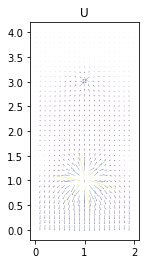

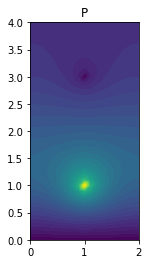

In [31]:
# Compute solution
w = Function(W)

solve(a==L, w, bc)
(u, p) = w.split()


#Plot sigma and u
file = File("flow.pvd")
file << w.split()[0]
plot(u, title = 'U')
plt.savefig('U.png')
plt.show()

file = File("pressure.pvd")
file << w.split()[1]
plot(p, title = 'P')
plt.savefig('P.png')
plt.show()